<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/NY_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the NY data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [17]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [18]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_Covid-19.csv     Newyork_combinedAug22.csv  NY-CovidAug22.csv
CA-CovidAug22.csv   Newyork_combined.csv       queens_all_combined.csv
mask_rule.csv	    NY_Covid-19.csv	       queens_all_filtered.csv
mask_rule_data.csv  NY-CovidAug21.csv	       Queens_county.csv


# Loading NY data

In [19]:
NY_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Newyork_combinedAug22.csv',low_memory=False)
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0


## Computing rolling average

In [22]:
NY_combined_data.iloc[:,15]

0       0
1       0
2       0
3       0
4       0
       ..
9685    1
9686    0
9687    0
9688    0
9689    0
Name: New cases, Length: 9690, dtype: int64

In [23]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [24]:
NY_counties = NY_combined_data['County Name'].unique()

for county in NY_counties:
  county_data = NY_combined_data[NY_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,NaN
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,NaN
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,NaN
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,NaN
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,NaN


In [25]:
print(df.shape)
NY_combined_data.shape

(9690, 17)


(9690, 16)

In [26]:
NY_combined_data = df.copy()
NY_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,NaN
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,NaN
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,NaN
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,NaN
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,2020-08-15,36123,Yates County,0.0,0.0,0.0,0.0,4.0,0.0,519.68,7.904,113,73.676584,1,0.884,1,0.428571
9686,2020-08-16,36123,Yates County,0.0,0.0,0.0,0.0,2.0,0.0,356.46,4.966,71,73.676584,1,0.884,0,0.285714
9687,2020-08-17,36123,Yates County,0.0,14.0,0.0,0.0,-23.0,0.0,281.57,4.181,60,73.676584,1,0.884,0,0.285714
9688,2020-08-18,36123,Yates County,0.0,0.0,0.0,0.0,0.0,0.0,276.14,3.576,51,73.676584,1,0.884,0,0.285714


In [27]:
NY_combined_data[NY_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
151,2020-08-01,36001,Albany County,-33.0,-10.0,0.0,-27.0,-14.0,1.0,35.56,2.260,47,584.364958,1,0.788,12,11.000000
321,2020-08-01,36003,Allegany County,-6.0,14.0,0.0,0.0,-12.0,0.0,138.45,5.929,105,44.778541,1,0.771,0,0.000000
491,2020-08-01,36007,Broome County,-21.0,-4.0,0.0,1.0,-14.0,1.0,91.40,2.238,49,269.900959,1,0.812,11,11.714286
661,2020-08-01,36009,Cattaraugus County,-13.0,51.0,0.0,0.0,-13.0,0.0,146.27,4.348,79,58.177858,1,0.793,0,1.142857
831,2020-08-01,36011,Cayuga County,-6.0,8.0,0.0,55.0,-7.0,-1.0,156.89,3.552,85,110.726163,1,0.732,1,0.714286
1001,2020-08-01,36013,Chautauqua County,-5.0,20.0,0.0,0.0,-13.0,0.0,156.76,2.867,73,119.693840,1,0.703,3,2.142857
1171,2020-08-01,36015,Chemung County,-21.0,0.0,0.0,-67.0,-2.0,-1.0,95.11,3.664,62,204.875414,1,0.594,0,0.428571
1341,2020-08-01,36017,Chenango County,-8.0,30.0,0.0,0.0,-5.0,0.0,137.06,5.034,65,52.830843,1,0.735,2,0.857143
1511,2020-08-01,36019,Clinton County,-19.0,4.0,0.0,-35.0,-10.0,-2.0,103.60,2.287,61,77.549742,1,0.773,1,1.142857
1681,2020-08-01,36021,Columbia County,-10.0,3.0,0.0,24.0,-10.0,0.0,154.44,3.446,37,93.682154,1,0.848,3,2.714286


In [28]:
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,NaN
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,NaN
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,NaN
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,NaN
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,NaN
5,2020-03-06,36001,Albany County,6.0,10.0,12.0,7.0,3.0,0.0,37.03,5.428,113,584.364958,0,0.0,0,NaN
6,2020-03-07,36001,Albany County,12.0,12.0,78.0,11.0,6.0,-1.0,21.45,3.992,83,584.364958,0,0.0,0,0.0
7,2020-03-08,36001,Albany County,9.0,13.0,186.0,7.0,2.0,-1.0,-6.01,2.550,53,584.364958,0,0.0,0,0.0


## clean data - fill NA 

In [29]:
NY_combined_data = NY_combined_data.fillna(0)
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,0.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,0.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,0.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,0.0
5,2020-03-06,36001,Albany County,6.0,10.0,12.0,7.0,3.0,0.0,37.03,5.428,113,584.364958,0,0.0,0,0.0
6,2020-03-07,36001,Albany County,12.0,12.0,78.0,11.0,6.0,-1.0,21.45,3.992,83,584.364958,0,0.0,0,0.0
7,2020-03-08,36001,Albany County,9.0,13.0,186.0,7.0,2.0,-1.0,-6.01,2.550,53,584.364958,0,0.0,0,0.0


In [30]:
NY_combined_data['County Name'].unique()

array(['Albany County', 'Allegany County', 'Broome County',
       'Cattaraugus County', 'Cayuga County', 'Chautauqua County',
       'Chemung County', 'Chenango County', 'Clinton County',
       'Columbia County', 'Cortland County', 'Delaware County',
       'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County',
       'Greene County', 'Herkimer County', 'Jefferson County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Rensselaer County', 'Rockland County',
       'St. Lawrence County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'Schuyler County', 'Seneca County',
       'Steuben County', 'Suffolk County', 'Sullivan County',
 

## verifying Rolling average with visualizations

In [31]:
albany_county = NY_combined_data[NY_combined_data['County Name'] == 'Albany County']
print(albany_county.shape)
albany_county.head()

(170, 17)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,0.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,0.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,0.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,0.0


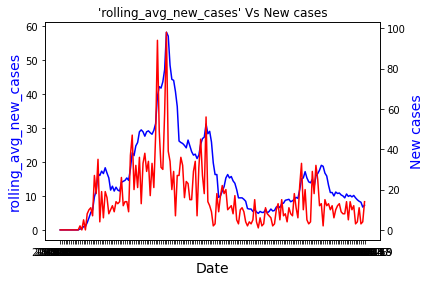

In [32]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.Date, albany_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(albany_county.Date, albany_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [33]:
NY_combined_data = NY_combined_data.sort_values(by=['Date'])
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
170,2020-03-01,36003,Allegany County,47.0,13.0,0.0,0.0,1.0,0.0,19.81,0.707,12,44.778541,0,0.0,0,0.0
9520,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0
9180,2020-03-01,36119,Westchester County,8.0,-1.0,12.0,1.0,0.0,0.0,-4.34,3.903,59,2247.400697,0,0.0,0,0.0
2380,2020-03-01,36031,Essex County,16.0,11.0,17.0,0.0,1.0,0.0,60.18,12.600,197,20.557565,0,0.0,0,0.0


In [34]:
NY_combined_data[NY_combined_data['fips_x'] == 36001]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,0.000000
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,0.000000
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,0.000000
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,0.000000
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2020-08-15,36001,Albany County,-33.0,-11.0,0.0,-31.0,-15.0,1.0,39.76,3.419,71,584.364958,1,0.788,4,8.857143
166,2020-08-16,36001,Albany County,-28.0,-10.0,0.0,-34.0,-14.0,1.0,16.22,1.363,28,584.364958,1,0.788,11,8.428571
167,2020-08-17,36001,Albany County,-21.0,1.0,76.0,-36.0,-45.0,12.0,37.64,2.712,56,584.364958,1,0.788,3,8.142857
168,2020-08-18,36001,Albany County,0.0,0.0,0.0,0.0,0.0,0.0,44.94,3.480,72,584.364958,1,0.788,4,6.714286


In [35]:
minDate = NY_combined_data['Date'].min()
print(minDate)

dateList = NY_combined_data['Date'].unique()

2020-03-01


In [36]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [37]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j -7
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-08', '2020-03-21']
[3, '2020-03-15', '2020-03-28']
[4, '2020-03-22', '2020-04-04']
[5, '2020-03-29', '2020-04-11']
[6, '2020-04-05', '2020-04-18']
[7, '2020-04-12', '2020-04-26']
[8, '2020-04-19', '2020-05-03']
[9, '2020-04-27', '2020-05-10']
[10, '2020-05-04', '2020-05-17']
[11, '2020-05-11', '2020-05-24']
[12, '2020-05-18', '2020-06-01']
[13, '2020-05-25', '2020-06-08']
[14, '2020-06-02', '2020-06-15']
[15, '2020-06-09', '2020-06-22']
[16, '2020-06-16', '2020-06-29']
[17, '2020-06-23', '2020-07-06']
[18, '2020-06-30', '2020-07-13']
[19, '2020-07-07', '2020-07-20']
[20, '2020-07-14', '2020-07-27']
[21, '2020-07-21', '2020-08-03']
[22, '2020-07-28', '2020-08-10']
[23, '2020-08-04', '2020-08-17']
[24, '2020-08-11', '2020-08-19']
[25, '2020-08-18', '2020-08-19']


In [38]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-08,2020-03-21


## Slice data for the week dataframe

In [39]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [40]:
average_newCases_df.shape

(1425, 5)

In [41]:
average_newCases_df[average_newCases_df['fips_x'] == 36001]

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,2.897959,2020-03-08,2020-03-21
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.459184,2020-03-22,2020-04-04
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,22.520408,2020-04-05,2020-04-18
0,Albany County,36001,30.132653,2020-04-12,2020-04-26
0,Albany County,36001,40.581633,2020-04-19,2020-05-03
0,Albany County,36001,40.244898,2020-04-27,2020-05-10
0,Albany County,36001,27.622449,2020-05-04,2020-05-17


## Verifying average per week data Eg., albany County

In [42]:
albany_county[(albany_county['Date'] >= '2020-03-01') & (albany_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.285714
12    0.285714
13    1.000000
Name: rolling_avg_new_cases, dtype: float64

In [43]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14
5,Chautauqua County,36013,0.000000,2020-03-01,2020-03-14
6,Chemung County,36015,0.000000,2020-03-01,2020-03-14
7,Chenango County,36017,0.000000,2020-03-01,2020-03-14
8,Clinton County,36019,0.000000,2020-03-01,2020-03-14
9,Columbia County,36021,0.000000,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [84]:
average_newCases_df_ = average_newCases_df.copy()

In [85]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Albany County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,2.897959,2020-03-08,2020-03-21
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.459184,2020-03-22,2020-04-04
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,22.520408,2020-04-05,2020-04-18
0,Albany County,36001,30.132653,2020-04-12,2020-04-26
0,Albany County,36001,40.581633,2020-04-19,2020-05-03
0,Albany County,36001,40.244898,2020-04-27,2020-05-10
0,Albany County,36001,27.622449,2020-05-04,2020-05-17


In [86]:
average_newCases_df = average_newCases_df.sort_values(by=['startDate'])

print(average_newCases_df.shape)
temp = average_newCases_df.groupby(['fips_x','startDate'])['average_per_week']
temp = temp.sum().diff().reset_index()

print(temp.shape)

average_newCases_df2 = average_newCases_df.merge(temp,on=['fips_x','startDate'])
print(average_newCases_df2.shape)

(1425, 5)
(1425, 3)
(1425, 6)


In [87]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Albany County']

,County Name,fips_x,average_per_week_x,startDate,endDate,average_per_week_y
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,NaN
86,Albany County,36001,2.897959,2020-03-08,2020-03-21,2.785714
153,Albany County,36001,11.122449,2020-03-15,2020-03-28,8.224490
212,Albany County,36001,14.459184,2020-03-22,2020-04-04,3.336735
263,Albany County,36001,14.785714,2020-03-29,2020-04-11,0.326531
324,Albany County,36001,22.520408,2020-04-05,2020-04-18,7.734694
370,Albany County,36001,30.132653,2020-04-12,2020-04-26,7.612245
438,Albany County,36001,40.581633,2020-04-19,2020-05-03,10.448980
495,Albany County,36001,40.244898,2020-04-27,2020-05-10,-0.336735
553,Albany County,36001,27.622449,2020-05-04,2020-05-17,-12.622449


In [88]:
average_newCases_df2[average_newCases_df2['fips_x'] == 36071].head(5)

,County Name,fips_x,average_per_week_x,startDate,endDate,average_per_week_y
1,Orange County,36071,0.112245,2020-03-01,2020-03-14,-1.102041
57,Orange County,36071,3.693878,2020-03-08,2020-03-21,3.581633
116,Orange County,36071,46.153061,2020-03-15,2020-03-28,42.459184
175,Orange County,36071,130.234694,2020-03-22,2020-04-04,84.081633
231,Orange County,36071,242.632653,2020-03-29,2020-04-11,112.397959


In [89]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week_x,startDate,endDate,average_per_week_y
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,NaN
1,Orange County,36071,0.112245,2020-03-01,2020-03-14,-1.102041
2,Orleans County,36073,0.000000,2020-03-01,2020-03-14,-12.857143
3,Oswego County,36075,0.000000,2020-03-01,2020-03-14,-0.642857
4,Otsego County,36077,0.000000,2020-03-01,2020-03-14,-2.428571


In [90]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [91]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week_x,startDate,endDate,average_per_week_y
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.000000
1,Orange County,36071,0.112245,2020-03-01,2020-03-14,-1.102041
2,Orleans County,36073,0.000000,2020-03-01,2020-03-14,-12.857143
3,Oswego County,36075,0.000000,2020-03-01,2020-03-14,-0.642857
4,Otsego County,36077,0.000000,2020-03-01,2020-03-14,-2.428571


In [73]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [112]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week_x'].shift()

In [113]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week_x  ...  percent_newcases
County Name   fips_x startDate  endDate                         ...                  
Albany County 36001  2020-03-01 2020-03-14            0.112245  ...          0.000000
                     2020-03-08 2020-03-21            2.897959  ...         24.818182
                     2020-03-15 2020-03-28           11.122449  ...          2.838028
                     2020-03-22 2020-04-04           14.459184  ...          0.300000
                     2020-03-29 2020-04-11           14.785714  ...          0.022583
...                                                        ...  ...               ...
Yates County  36123  2020-07-21 2020-08-03            0.214286  ...         -0.045455
                     2020-07-28 2020-08-10            0.367347  ...          0.714286
                     2020-08-04 2020-08-17            0.336735  ...         -0.083333
                     2020-08-11 2020-08-19            0.269841  ...         -0.198653
                     2020-08-18 2020-08-19            0.285714  ...          0.058824

[1425 rows x 4 columns]

In [114]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.average_per_week_y) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.head()


,County Name,fips_x,average_per_week_x,startDate,endDate,average_per_week_y,shift_avg_x,percent_newcases
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.000000,NaN,0.0
1,Orange County,36071,0.112245,2020-03-01,2020-03-14,-1.102041,NaN,0.0
2,Orleans County,36073,0.000000,2020-03-01,2020-03-14,-12.857143,NaN,0.0
3,Oswego County,36075,0.000000,2020-03-01,2020-03-14,-0.642857,NaN,0.0
4,Otsego County,36077,0.000000,2020-03-01,2020-03-14,-2.428571,NaN,0.0


In [116]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week_x  ...  percent_newcases
County Name   fips_x startDate  endDate                         ...                  
Albany County 36001  2020-03-01 2020-03-14            0.112245  ...          0.000000
                     2020-03-08 2020-03-21            2.897959  ...         24.818182
                     2020-03-15 2020-03-28           11.122449  ...          2.838028
                     2020-03-22 2020-04-04           14.459184  ...          0.300000
                     2020-03-29 2020-04-11           14.785714  ...          0.022583
...                                                        ...  ...               ...
Yates County  36123  2020-07-21 2020-08-03            0.214286  ...         -0.045455
                     2020-07-28 2020-08-10            0.367347  ...          0.714286
                     2020-08-04 2020-08-17            0.336735  ...         -0.083333
                     2020-08-11 2020-08-19            0.269841  ...         -0.198653
                     2020-08-18 2020-08-19            0.285714  ...          0.058824

[1425 rows x 4 columns]

In [118]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

,County Name,fips_x,average_per_week_x,startDate,endDate,average_per_week_y,shift_avg_x,percent_newcases
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.000000,NaN,0.000000
1,Orange County,36071,0.112245,2020-03-01,2020-03-14,-1.102041,NaN,0.000000
2,Orleans County,36073,0.000000,2020-03-01,2020-03-14,-12.857143,NaN,0.000000
3,Oswego County,36075,0.000000,2020-03-01,2020-03-14,-0.642857,NaN,0.000000
4,Otsego County,36077,0.000000,2020-03-01,2020-03-14,-2.428571,NaN,0.000000
...,...,...,...,...,...,...,...,...
1420,Monroe County,36055,29.785714,2020-08-18,2020-08-19,0.246032,29.539683,0.008329
1421,Wyoming County,36121,0.285714,2020-08-18,2020-08-19,-0.031746,0.317460,-0.100000
1422,Delaware County,36025,0.214286,2020-08-18,2020-08-19,-0.087302,0.301587,-0.289474
1423,Montgomery County,36057,1.642857,2020-08-18,2020-08-19,-0.119048,1.761905,-0.067568


# unused code


In [ ]:
agg_gains_df = (
    average_newCases_df2
    .pipe(lambda x: x.assign(gains_pctg=x.average_per_week_y/x.average_per_week_x))
    .groupby(['County Name', 'fips_x','startDate'])
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "weekly_growth"})
)

In [ ]:
week_df.head()

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-08,2020-03-21
2,3,2020-03-15,2020-03-28
3,4,2020-03-22,2020-04-04
4,5,2020-03-29,2020-04-11


In [ ]:
NY_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
dtype: object

In [ ]:
start_date_df = (
    NY_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

,County Name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,Albany County,0.0,0.000000,1.000000,16.571429,11.714286,14.285714,24.714286,29.142857,41.714286,44.000000,24.142857,22.000000,25.857143,12.714286,11.857143,6.142857,5.142857,5.714286,8.857143,11.857143,14.857143,16.714286,10.714286,10.142857,6.714286
1,Allegany County,0.0,0.000000,0.000000,0.285714,0.571429,1.428571,1.428571,0.571429,0.714286,0.000000,0.428571,0.857143,0.000000,0.571429,0.428571,0.571429,0.428571,0.142857,0.571429,0.714286,0.571429,0.285714,0.142857,0.714286,0.000000
2,Broome County,0.0,0.000000,0.142857,0.285714,3.714286,6.000000,7.857143,9.428571,8.857143,10.428571,6.285714,6.428571,13.714286,6.714286,7.000000,4.142857,2.142857,6.428571,6.571429,11.285714,10.857143,10.714286,12.285714,9.285714,4.857143
3,Cattaraugus County,0.0,0.000000,0.000000,0.000000,0.571429,0.857143,2.571429,0.857143,1.571429,1.142857,1.142857,0.857143,2.000000,1.000000,0.857143,1.714286,1.571429,0.714286,0.714286,1.571429,1.142857,0.857143,1.571429,0.571429,0.571429
4,Cayuga County,0.0,0.000000,0.000000,0.000000,0.285714,0.857143,3.285714,0.714286,1.714286,0.428571,1.285714,0.714286,1.714286,1.571429,1.285714,0.571429,0.285714,1.000000,1.000000,0.714286,0.571429,1.285714,1.428571,1.000000,1.000000
5,Chautauqua County,0.0,0.000000,0.000000,0.000000,1.000000,1.571429,0.714286,0.285714,0.714286,1.000000,0.571429,1.142857,3.714286,1.428571,2.428571,0.714286,1.142857,1.571429,1.142857,6.428571,3.714286,1.857143,3.142857,2.428571,1.857143
6,Chemung County,0.0,0.000000,0.000000,0.000000,2.142857,3.285714,3.142857,1.857143,5.000000,2.571429,0.714286,0.428571,0.285714,0.000000,0.142857,0.000000,0.142857,0.285714,0.857143,0.285714,0.857143,0.714286,0.428571,1.857143,2.000000
7,Chenango County,0.0,0.000000,0.000000,0.285714,1.857143,4.000000,2.857143,2.142857,2.428571,0.714286,1.571429,1.000000,0.142857,1.428571,0.285714,0.571429,0.285714,0.714286,1.571429,2.000000,2.428571,2.142857,1.285714,0.857143,0.000000
8,Clinton County,0.0,0.000000,0.000000,0.571429,1.285714,2.857143,1.428571,0.857143,1.142857,1.285714,1.142857,2.571429,0.142857,0.285714,0.000000,0.285714,0.142857,0.142857,0.571429,0.714286,0.571429,1.285714,0.571429,0.285714,0.714286
9,Columbia County,0.0,0.000000,0.000000,2.428571,1.857143,5.571429,2.571429,2.857143,5.000000,9.571429,14.428571,4.571429,3.714286,2.428571,3.285714,4.000000,1.714286,1.428571,2.142857,1.428571,0.857143,1.285714,3.571429,2.428571,1.714286


In [ ]:
end_date_df = (
    NY_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

KeyError: ignored